## Cell 1
In this cell, we import all the libraries needed for the project:
- **NumPy** and **Pandas** for data handling.
- **TensorFlow** (with `layers` and `models`) for building and training the CNN.
- **sklearn.model_selection** for splitting the data into training and validation sets.
- **sklearn.metrics** for performance metrics.
- (Optionally) `KerasClassifier` from `scikeras.wrappers`, if we decide to wrap our Keras model for scikit-learn.

In [89]:
import numpy as np
import pandas as pd

# For the CNN model
import tensorflow as tf
from tensorflow.keras import layers, models

# For splitting data and evaluating performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Import necessary libraries for ROC curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


## Cell 2
Here, we:
1. Define a `project_dir` to keep track of where our data files are located.
2. Construct full paths for the training and test CSV files.
3. Read these CSV files into Pandas DataFrames (`df_train` and `df_test`) without headers, since we know the data doesn't have a header row.

In [90]:
train_file_path = './trainData/53_train.csv'
test_file_path = './trainData/53_test.csv'


df_train = pd.read_csv(train_file_path, header=None)
df_test  = pd.read_csv(test_file_path, header=None)

def replace_zeros_with_mean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()  
    for col in df.columns:
        non_zero_mean = df.loc[df[col] != 0, col].mean()
        df.loc[df[col] == 0, col] = non_zero_mean
    return df

df_train_no_zeros = replace_zeros_with_mean(df_train)
df_test_no_zeros  = replace_zeros_with_mean(df_test)


## Cell 3
- We build the target vector `y` which has 0 for the first 2500 samples and 1 for the next 2500 samples.
- We reshape our training data into a 4D array suitable for a CNN: `(number of samples, height=8, width=9, channels=1)`.

In [91]:
y = np.array([0] * 2500 + [1] * 2500)

X = df_train.values.reshape(-1, 8, 9, 1)

## Cell 4
1. We split our data (`X`, `y`) into training and validation subsets using an 80/20 ratio.
2. We construct a simple convolutional neural network:
   - **Conv2D** layers for feature extraction.
   - **MaxPooling2D** to reduce spatial dimensions.
   - **Flatten** to convert 2D feature maps into a 1D vector.
   - **Dense** layers for classification.
3. We compile the model with **Adam** optimizer and **sparse_categorical_crossentropy** loss (suitable for integer labels).

In [92]:
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(8, 9, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')
])

cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Cell 5
We train the CNN model with:
- **50 epochs**,
- **batch size** of 32,
- using our training data and labels (`X_train`, `y_train`) and validating on (`X_val`, `y_val`).
The training output is stored in `history`, which tracks loss and accuracy over epochs.

In [93]:
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6920 - loss: 1.6590 - val_accuracy: 0.8270 - val_loss: 0.3837
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.8326 - loss: 0.3997 - val_accuracy: 0.8570 - val_loss: 0.3361
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.8420 - loss: 0.3943 - val_accuracy: 0.8180 - val_loss: 0.4634
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.8717 - loss: 0.3112 - val_accuracy: 0.8730 - val_loss: 0.3065
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.8694 - loss: 0.3032 - val_accuracy: 0.8740 - val_loss: 0.2778
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.8973 - loss: 0.2608 - val_accuracy: 0.8740 - val_loss: 0.2845
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.8912 - loss: 0.2651 - val_accuracy: 0.8960 - val_loss: 0.2485
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9073 - loss: 0.2205 - va

## Cell 6
- We reshape the test data (`df_test`) to the same shape as the training data for predictions if needed.
- Here, we demonstrate prediction on the validation set (`X_val`) and compute:
  - The distribution of predicted classes.
  - The accuracy and error rate.
  - The classification report, which provides precision, recall, and F1 scores.
- Finally, we print out class distribution and performance metrics.


In [94]:
# Reshape the test data the same way as training
X_test = df_test.values.reshape(-1, 8, 9, 1)

# Predict on the validation set to evaluate performance
y_pred_proba = cnn_model.predict(X_val)
y_pred_label = np.argmax(y_pred_proba, axis=1)

# Determine the distribution of predicted classes
unique_labels, label_counts = np.unique(y_pred_label, return_counts=True)
class_distribution = dict(zip(unique_labels, label_counts))

# Display results
print("Predicted Class Distribution:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} records")

print("\nClass Split:")
total_pred_samples = len(y_pred_label)
for label, count in class_distribution.items():
    pct = (count / total_pred_samples) * 100
    print(f"Class {label}: {pct:.2f}%")

acc = accuracy_score(y_val, y_pred_label)
err = 1 - acc
print(f"\nAccuracy: {acc:.2f}")
print(f"Error Rate: {err:.2f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred_label))

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step
Predicted Class Distribution:
Class 0: 496 records
Class 1: 504 records

Class Split:
Class 0: 49.60%
Class 1: 50.40%

Accuracy: 0.93
Error Rate: 0.07

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       500
           1       0.92      0.93      0.93       500

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [101]:
y_test_proba = cnn_model.predict(X_test)
y_test_label = np.argmax(y_test_proba, axis=1)  
test_class_vals, test_class_counts = np.unique(y_test_label, return_counts=True)
class_proportions_test = {
    c_val: c_count / len(y_test_label) for c_val, c_count in zip(test_class_vals, test_class_counts)
    
}
prop_str_test = "-".join([
    f"{class_proportions_test[c_val]:.2f}" for c_val in sorted(class_proportions_test.keys())
])

print("Test Set Predicted Class Distribution:")
for c_val, c_count in zip(test_class_vals, test_class_counts):
    print(f"Class {c_val}: {c_count} records ({class_proportions_test[c_val] * 100:.2f}%)")

print(f"\nClass split: {prop_str_test}")

output_path = f"output/ccn_output.csv"
pd.DataFrame(y_test_label, columns=['Class']).to_csv(output_path, index=False, header=False)

print(f"\nTest predictions saved to: {output_path}")


1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step
Test Set Predicted Class Distribution:
Class 0: 33153 records (66.31%)
Class 1: 16847 records (33.69%)

Class split: 0.66-0.34

Test predictions saved to: output/ccn_output.csv


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step
Predicted Class Distribution:
Class 0: 530 records
Class 1: 470 records

Class Split:
Class 0: 53.00%
Class 1: 47.00%

Accuracy: 0.91
Error Rate: 0.09

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.94      0.92       500
           1       0.94      0.88      0.91       500

    accuracy                           0.91      1000
   macro avg       0.92      0.91      0.91      1000
weighted avg       0.92      0.91      0.91      1000



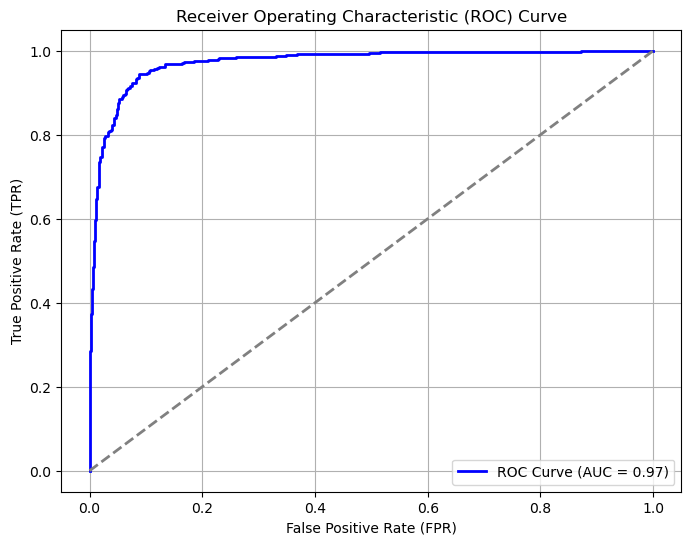

In [ ]:
X_test = df_test.values.reshape(-1, 8, 9, 1)

y_pred_proba = cnn_model.predict(X_val)
y_pred_label = np.argmax(y_pred_proba, axis=1)

unique_labels, label_counts = np.unique(y_pred_label, return_counts=True)
class_distribution = dict(zip(unique_labels, label_counts))

print("Predicted Class Distribution:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} records")

print("\nClass Split:")
total_pred_samples = len(y_pred_label)
for label, count in class_distribution.items():
    pct = (count / total_pred_samples) * 100
    print(f"Class {label}: {pct:.2f}%")

acc = accuracy_score(y_val, y_pred_label)
err = 1 - acc
print(f"\nAccuracy: {acc:.2f}")
print(f"Error Rate: {err:.2f}")

print("\nClassification Report:\n", classification_report(y_val, y_pred_label))

fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba[:, 1]) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
